<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://diretorio.bad.pt/wp-content/uploads/2015/09/55c9dc4270c60-IMS-rgb_logo.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color:rgb(190, 214, 47);">CIFO Project |</span> <span style="color:rgb(92, 102, 108);">Sports League Optimization using Genetic Algorithms</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>Diogo Duarte, 20240525</div>
            <div>Rodrigo Sardinha, 20211627</div>
            <div>Rui Luz, 20211628</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group AE
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right,rgb(190, 214, 47), rgb(92, 102, 108));
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

# 📋 **0. Table of Contents**

- [**🔎 1. Project Overview**](#1-project-overview)
- [**📚 2. Imports**](#2-imports)
- [**👣 3. First Setps**](#3-steps)
- [**🦋 4. Mutations**](#4-mutations)
- [**🔀 5. Crossovers**](#5-crossovers)
- [**🫵 6. Selection**](#6-selection)
- [**🧬 7. Genetic Algorithms**](#7-genetic)

# 🔎 **1. Project Overview** <a id="1-project-overview"></a>

The **goal** of this project is to apply **Genetic Algorithms** to solve an optimization problem.

### ⚽ **1.1. Concept**

In  a  fantasy  sports  league,  the  objective  is  to  assign  players  to  teams  in  a  way  that  ensures a balanced distribution of talent while staying within salary caps.

Each player is defined by the following attributes:
- **Skill rating**: Represents the player's ability.
- **Cost**: The player's salary.
- **Position**: One of four roles: Goalkeeper (GK), Defender (DF), Midfielder (MF), and Forward (FW).

A solution is a complete league configuration, specifying the team assignment for each player.


### ⛔ **1.2. Constraints**

No object is considered a solution if it doesn't comply with:
 - Each team must precisely consist of: 1 Goalkeeper, 2 Defenders, 2 Midfielders, and 2 Forwards.
 - Each player is assigned to exactly one team.
 - Each team should not exceed a 750€ millon total budget.
 - Players should be distributed across **5 teams** of **7 players each**.

In [507]:
team_structure = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2} # each team must consist of this structure
budget_limit = 750 # in €M
num_teams = 5 # 5 teams to be created
team_size = 7 # teams of 7 players

### 🥅 **1.3. Goal**

The objective is to create a balanced league that complies with the constraints.

A balanced league is a league where the average skill rating of the players is roughly the same among the teams, which can be measured by the **standard deviation** of the average skill rating of the teams.

# 📚 **2. Imports** <a id="2-imports"></a>

### 📖 **2.1. Libraries and Modules**

In [508]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter

from utils.Classes import Player, Team, LeagueIndividual
from utils.combinations import evaluate_all_combinations 
from algorithms.GA_mutation import mutation_swap_players, mutation_regenerate_team, mutation_balance_teams
from algorithms.GA_crossover import team_crossover, position_crossover
from algorithms.GA_selection import sel_roulette, sel_rank, sel_tournament
from algorithms.algorithm import genetic_algorithm 
from solutions.GASolution import GASolution

### 📊 **2.2. Player Data**

Metadata: <a id="2-2-1-metadata"></a>
- `Name`: Player's name.
- `Position`: One of four roles: Goalkeeper (GK), Defender (DF), Midfielder (MF), and Forward (FW).
- `Skill`: Represents the player's ability.
- `Salary (€M)`: The player's salary.

In [509]:
df = pd.read_csv("data/players.csv")
df = df.drop(columns=['Unnamed: 0']) # drop the index column

# 👣 **3. First Steps** <a id="3-steps"></a>

### ⚙️ **3.1. Setup**

Setting inital population size and number of generations.

In [510]:
# Fixed values to start from
population_size = 30 
generations = 100

Create a list of player objects from the player dataframe.

In [511]:
# Create a dictionary of players by position
players_by_position = {
    pos: [Player.from_dict(row) for _, row in df[df['Position'] == pos].iterrows()]
    for pos in team_structure
}

### 👥 **3.2. Inital Population**

In [512]:
# Setting the initial iteration
def generate_initial_population(size, players_by_position, team_structure, budget_limit, num_teams):
    """
    Generate an initial population of LeagueIndividuals.
    Each individual is a LeagueIndividual object that represents a league of teams.

    Args:
        size (int): The number of individuals to generate.
        players_by_position (dict): A dictionary where keys are positions and values are lists of Player objects.
        team_structure (dict): A dictionary defining the structure of each team (e.g., number of players per position).
        budget_limit (float): The budget limit for the league.
        num_teams (int): The number of teams in the league.

    Returns:
        list: A list of LeagueIndividual objects representing the initial population.
    """
    population = []
    attempts = 0
    max_attempts = 1000 # avoid infinite loop if unable to generate valid leagues

    while len(population) < size and attempts < max_attempts:
        indiv = LeagueIndividual(players_by_position, team_structure, budget_limit, num_teams)
        if indiv.league is not None: # proceed if the league is valid
            population.append(indiv)
        attempts += 1

    return population

# Print the entire population
def print_population(population):
    """
    Print the details of each individual in the population.
    Each individual is a LeagueIndividual object that represents a league of teams.

    Args:
        population (list): A list of LeagueIndividual objects.
    """
    for i, indiv in enumerate(population):
        print(f"\nLeague {i+1} | Fitness: {indiv.fitness:.4f}")
        print()
        all_names = set()
        for j, team in enumerate(indiv.league): # iterate through each team in the league
            names = [p.name for p in team.players]
            positions = [p.position for p in team.players]
            skill = team.avg_skill()
            salary = team.total_salary()
            print(f"    - Team {j+1} | Positions: {positions} | Avg Skill: {skill:.2f} | Salary: {salary}M")

            # Check for duplicate players within individual
            duplicates = set(names).intersection(all_names)
            if duplicates:
                print(f"Duplicate Players: {duplicates}")
            all_names.update(names)

In [513]:
# Generate the initial iteration
population = generate_initial_population(
    population_size,
    players_by_position,
    team_structure,
    budget_limit, 
    num_teams
)

print_population(population)


League 1 | Fitness: 1.5476

    - Team 1 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 84.43 | Salary: 629M
    - Team 2 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 88.00 | Salary: 725M
    - Team 3 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 88.29 | Salary: 735M
    - Team 4 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 86.29 | Salary: 685M
    - Team 5 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 85.00 | Salary: 650M

League 2 | Fitness: 0.9664

    - Team 1 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 86.43 | Salary: 680M
    - Team 2 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 87.86 | Salary: 725M
    - Team 3 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'FWD'] | Avg Skill: 85.43 | Salary: 649M
    - Team 4 | Positions: ['GK', 'DEF', 'DEF', 'MID', 'MID', 'FWD', 'F

# 🦋 **4. Mutations** <a id="4-mutations"></a>

### 🔄 **4.1. Swap Players Betweeen Teams**

In [ ]:
individual = random.choice(population)

In [515]:
print(individual)

<LeagueIndividual fitness=1.0158>


In [ ]:
# Apply the mutation that swaps players between teams
swap_players = mutation_swap_players(individual)
print(swap_players)

<LeagueIndividual fitness=0.9873>


In [ ]:
# Check if the mutation actually changed the individual 
if swap_players == individual:
    print("No mutation applied (swap failed after multiple attempts).")
else:
    print("Mutation applied successfully.")

✅ Mutation applied successfully.


Testing code mutation_swap_players

In [ ]:
# Test mutation_swap_players function 
def print_league_details(league_indiv, label=""):
    """

    Print league details including fitness, teams, players, and validation checks.
    """
    print(f"\n{'='*50}\n    {label} (Fitness: {league_indiv.fitness:.4f})\n{'='*50}")
    
    all_players = set()
    valid = True

    for i, team in enumerate(league_indiv.league):
        print(f"\n  Team {i+1}")
        for player in team.players:
            print(f"  - {player}")
        avg = team.avg_skill()
        total_salary = team.total_salary()
        print(f"  Avg Skill: {avg:.2f} |Total Salary: €{total_salary}M")
        
        all_players.update(player.name for player in team.players)

        if not team.is_valid(league_indiv.team_structure, league_indiv.budget_limit):
            print("Invalid team (structure or budget)")
            valid = False

    # check for duplicate players
    expected_total = sum(league_indiv.team_structure.values()) * len(league_indiv.league)
    if len(all_players) != expected_total:
        print("Duplicate players found across teams!")
        valid = False

    print(f"\nValid League: {valid}")
    return valid


mutated = mutation_swap_players(individual)

print_league_details(individual, "Original League")
print_league_details(mutated, "Mutated League")


    Original League (Fitness: 1.0158)

  Team 1
  - GK: Blake Henderson | Skill: 87 | Salary: €95M
  - DEF: Lucas Bennett | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - MID: Bentley Rivera | Skill: 88 | Salary: €100M
  - FWD: Sebastian Perry | Skill: 95 | Salary: €150M
  - FWD: Colton Gray | Skill: 91 | Salary: €125M
  Avg Skill: 88.29 |Total Salary: €747M

  Team 2
  - GK: Chris Thompson | Skill: 80 | Salary: €80M
  - DEF: Jaxon Griffin | Skill: 79 | Salary: €65M
  - DEF: Brayden Hughes | Skill: 87 | Salary: €100M
  - MID: Nathan Wright | Skill: 92 | Salary: €120M
  - MID: Connor Hayes | Skill: 89 | Salary: €105M
  - FWD: Landon Powell | Skill: 89 | Salary: €110M
  - FWD: Chase Murphy | Skill: 86 | Salary: €95M
  Avg Skill: 86.00 |Total Salary: €675M

  Team 3
  - GK: Alex Carter | Skill: 85 | Salary: €90M
  - DEF: Caleb Fisher | Skill: 84 | Salary: €85M
  - DEF: Logan Brooks | Skill: 86 | Salary: €9

True

### 🌱 **4.2. Regenerate a Team Entirely**

In [ ]:
regenerate_team = mutation_regenerate_team(individual)
print(regenerate_team)

<LeagueIndividual fitness=0.8590>


In [ ]:
# Check if the mutation actually changed the individual 
if regenerate_team == individual:
    print("No mutation applied (regenerate team failed).")
else:
    print("Mutation applied successfully.")

✅ Mutation applied successfully.


Testing code mutation_regenerate_team

In [ ]:
def print_player_diff(orig_players, new_players):
    """
    
    Compare players before and after mutation.
    Args:  
        orig_players (list): List of original Player objects.
        new_players (list): List of mutated Player objects.
    Returns:
        tuple: A tuple containing two sets: added and removed players.
    """
    orig_names = set(p.name for p in orig_players)
    new_names = set(p.name for p in new_players)
    added = new_names - orig_names
    removed = orig_names - new_names
    return added, removed

def print_detailed_comparison(original, mutated):
    """
    
    Print a detailed comparison of the original and mutated league.
    Args:
        original (LeagueIndividual): The original league individual.
        mutated (LeagueIndividual): The mutated league individual.
    """
    print(f"\n{'='*60}")
    print(f" Regenerate Team Mutation Comparison")
    print(f" Fitness: {original.fitness:.4f} → {mutated.fitness:.4f}")
    print(f"{'='*60}\n")

    # determine the regenerated team
    max_changes = 0
    regenerated_team_index = None
    for i, (team_orig, team_mut) in enumerate(zip(original.league, mutated.league)):
        orig_names = set(p.name for p in team_orig.players)
        new_names = set(p.name for p in team_mut.players)
        changes = len(orig_names.symmetric_difference(new_names))
        if changes > max_changes:
            max_changes = changes
            regenerated_team_index = i

    # print teams
    for i, (team_orig, team_mut) in enumerate(zip(original.league, mutated.league)):
        team_label = f" Team {i+1}"
        if i == regenerated_team_index:
            team_label += "    --------------->   (Regenerated Team)"
        print(f"\n{team_label}")
        print(f"  Original Team:")
        for p in team_orig.players:
            print(f"  - {p}")
        print(f"     Avg Skill: {team_orig.avg_skill():.2f} |  Salary: €{team_orig.total_salary()}M")

        print(f"\n  Mutated Team:")
        for p in team_mut.players:
            print(f"  - {p}")
        print(f"     Avg Skill: {team_mut.avg_skill():.2f} |  Salary: €{team_mut.total_salary()}M")

        added, removed = print_player_diff(team_orig.players, team_mut.players)
        if added or removed:
            print(f"     Added: {', '.join(added) if added else 'None'}")
            print(f"     Removed: {', '.join(removed) if removed else 'None'}")

    print(f"\n League Valid: {all(team.is_valid(mutated.team_structure, mutated.budget_limit) for team in mutated.league)}")
    print(f" Regenerated Team: Team {regenerated_team_index + 1 if regenerated_team_index is not None else 'Unknown'}")

In [ ]:
mutated = mutation_regenerate_team(individual)
print_detailed_comparison(individual, mutated)


 Regenerate Team Mutation Comparison
 Fitness: 1.0158 → 0.6725


 Team 1
  Original Team:
  - GK: Blake Henderson | Skill: 87 | Salary: €95M
  - DEF: Lucas Bennett | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - MID: Bentley Rivera | Skill: 88 | Salary: €100M
  - FWD: Sebastian Perry | Skill: 95 | Salary: €150M
  - FWD: Colton Gray | Skill: 91 | Salary: €125M
     Avg Skill: 88.29 |  Salary: €747M

  Mutated Team:
  - DEF: Lucas Bennett | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - FWD: Sebastian Perry | Skill: 95 | Salary: €150M
  - FWD: Colton Gray | Skill: 91 | Salary: €125M
  - GK: Chris Thompson | Skill: 80 | Salary: €80M
  - MID: Connor Hayes | Skill: 89 | Salary: €105M
     Avg Skill: 87.43 |  Salary: €737M
     Added: Connor Hayes, Chris Thompson
     Removed: Blake Henderson, Bentley Rivera

 Team 2    ------

### ⚖️ **4.3. Balance Teams Average Skill (StDev.)**

In [523]:
# Apply the mutation that balances teams by swapping players between strongest and weakest teams
third_mutation = mutation_balance_teams(individual)
print(third_mutation)

<LeagueIndividual fitness=0.7845>


In [524]:
# Check if the mutation actually changed the individual 
if third_mutation == individual:
    print("⚠️  No mutation applied (swap failed after multiple attempts).")
else:
    print("✅ Mutation applied successfully.")

✅ Mutation applied successfully.


Testing code mutation_balance_teams

In [525]:
def print_player_diff(orig_players, new_players):
    """

    Compare players before and after mutation.
    Args:
        orig_players (list): List of original Player objects.
        new_players (list): List of mutated Player objects.
    Returns:
        tuple: A tuple containing two sets: added and removed players.
    """
    orig_names = set(p.name for p in orig_players)
    new_names = set(p.name for p in new_players)
    added = new_names - orig_names
    removed = orig_names - new_names
    return added, removed

def print_detailed_comparison(original, mutated):
    """
    
    Print comparison between original and mutated league
    Args:
        original (LeagueIndividual): The original league individual.
        mutated (LeagueIndividual): The mutated league individual.
    """
    print(f"\n{'='*60}")
    print(f" Mutation Comparison")
    print(f" Fitness: {original.fitness:.4f} → {mutated.fitness:.4f}")
    print(f"{'='*60}\n")

    # Identify most-changed team
    max_changes = 0
    regenerated_team_index = None
    for i, (t1, t2) in enumerate(zip(original.league, mutated.league)):
        orig_names = set(p.name for p in t1.players)
        new_names = set(p.name for p in t2.players)
        changes = len(orig_names.symmetric_difference(new_names))
        if changes > max_changes:
            max_changes = changes
            regenerated_team_index = i

    # Print comparison
    for i, (t1, t2) in enumerate(zip(original.league, mutated.league)):
        team_label = f" Team {i+1}" + ("     --------------------->    (NEW)" if i == regenerated_team_index else "")
        print(f"\n{team_label}")
        print("  Original Team:")
        for p in t1.players:
            print(f"  - {p}")
        print(f"    Avg Skill: {t1.avg_skill():.2f} |  Salary: €{t1.total_salary()}M")

        print("\n Mutated Team:")
        for p in t2.players:
            print(f"  - {p}")
        print(f"     Avg Skill: {t2.avg_skill():.2f} |  Salary: €{t2.total_salary()}M")

        added, removed = print_player_diff(t1.players, t2.players)
        if added or removed:
            print(f"     Added: {', '.join(added) if added else 'None'}")
            print(f"     Removed: {', '.join(removed) if removed else 'None'}")

    print(f"\n League Valid: {all(t.is_valid(mutated.team_structure, mutated.budget_limit) for t in mutated.league)}")
    print(f" Most changed team: Team {regenerated_team_index + 1 if regenerated_team_index is not None else 'Unknown'}")

In [526]:
# test the mutation_balance_teams function
def test_mutation_balance_teams():

    print("\n=== Testing: mutation_balance_teams ===")

    # Generate a sample individual
    mutated = mutation_balance_teams(individual)

    # Compare fitness
    print(f"\n Original Fitness: {individual.fitness:.4f}")
    print(f" Mutated Fitness:  {mutated.fitness:.4f}")

    # Identify changed teams
    changed_teams = []
    for i, (t1, t2) in enumerate(zip(individual.league, mutated.league)):
        if set(p.name for p in t1.players) != set(p.name for p in t2.players):
            changed_teams.append(i + 1)

    if mutated.fitness < individual.fitness:
        print("\n Mutation successful! Fitness improved.")
    else:
        print("\n No mutation applied. Fitness unchanged.")

    print(f"\n Changed team(s): {changed_teams if changed_teams else 'None'}")

    # Optionally, print detailed comparison
    print_detailed_comparison(individual, mutated)

In [527]:
test_mutation_balance_teams()


=== Testing: mutation_balance_teams ===

 Original Fitness: 1.0158
 Mutated Fitness:  0.4642

 Mutation successful! Fitness improved.

 Changed team(s): [1, 4]

 Mutation Comparison
 Fitness: 1.0158 → 0.4642


 Team 1     --------------------->    (NEW)
  Original Team:
  - GK: Blake Henderson | Skill: 87 | Salary: €95M
  - DEF: Lucas Bennett | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - MID: Bentley Rivera | Skill: 88 | Salary: €100M
  - FWD: Sebastian Perry | Skill: 95 | Salary: €150M
  - FWD: Colton Gray | Skill: 91 | Salary: €125M
    Avg Skill: 88.29 |  Salary: €747M

 Mutated Team:
  - GK: Blake Henderson | Skill: 87 | Salary: €95M
  - DEF: Lucas Bennett | Skill: 85 | Salary: €90M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - MID: Bentley Rivera | Skill: 88 | Salary: €100M
  - FWD: Adrian Collins | Skill: 85 | Salary: €90M
  - FWD: Colt

# 🔀 **5. Crossovers** <a id="5-crossovers"></a>

In [528]:
# Generate Parents
parent1 = population[0]
parent2 = population[1]

### 🔗 **5.1. Crossover by Team**

In [529]:
# Apply team crossover
child1_team, child2_team = team_crossover(parent1, parent2)

In [ ]:
# Simple identity check
if child1_team == parent1 and child2_team == parent2:
    print("No crossover effect — children are identical to parents.")
else:
    print("Crossover applied successfully.")


✅ Crossover applied successfully.


Testing code team_crossover

In [531]:
# === TEAM_CROSSOVER TESTING ===

# printer for LeagueIndividuals
def print_league(individual, label):
    print(f"\n{label} | Fitness: {individual.fitness:.4f}")
    for i, team in enumerate(individual.league):
        print(f" Team {i+1}:")
        for p in team.players:
            print(f"    {p.name} ({p.position}) -  Skill: {p.skill} -  Salary: €{p.salary}M")


# Print parents and children
print_league(parent1, "Parent 1")
print_league(parent2, "Parent 2")
print_league(child1_team,  "Child 1 (Team Crossover)")
print_league(child2_team,  "Child 2 (Team Crossover)")


Parent 1 | Fitness: 1.5476
 Team 1:
    Chris Thompson (GK) -  Skill: 80 -  Salary: €80M
    Jaxon Griffin (DEF) -  Skill: 79 -  Salary: €65M
    Maxwell Flores (DEF) -  Skill: 81 -  Salary: €72M
    Dominic Bell (MID) -  Skill: 86 -  Salary: €95M
    Connor Hayes (MID) -  Skill: 89 -  Salary: €105M
    Zachary Nelson (FWD) -  Skill: 86 -  Salary: €92M
    Xavier Bryant (FWD) -  Skill: 90 -  Salary: €120M
 Team 2:
    Blake Henderson (GK) -  Skill: 87 -  Salary: €95M
    Owen Parker (DEF) -  Skill: 88 -  Salary: €100M
    Caleb Fisher (DEF) -  Skill: 84 -  Salary: €85M
    Bentley Rivera (MID) -  Skill: 88 -  Salary: €100M
    Gavin Richardson (MID) -  Skill: 87 -  Salary: €95M
    Landon Powell (FWD) -  Skill: 89 -  Salary: €110M
    Elijah Sanders (FWD) -  Skill: 93 -  Salary: €140M
 Team 3:
    Jordan Smith (GK) -  Skill: 88 -  Salary: €100M
    Logan Brooks (DEF) -  Skill: 86 -  Salary: €95M
    Daniel Foster (DEF) -  Skill: 90 -  Salary: €110M
    Dylan Morgan (MID) -  Skill: 91 

### 📢 **5.2. Crossover by Position**

In [532]:
# Apply position crossover
child1_pos, child2_pos = position_crossover(parent1, parent2)

In [533]:
# Simple identity check
if child1_pos == parent1 and child2_pos == parent2:
    print("⚠️  No crossover effect — children are identical to parents.")
else:
    print("✅ Crossover applied successfully.")


✅ Crossover applied successfully.


Testing code position_crossover

In [534]:
# print LeagueIndividuals
def print_league(individual, label):
    print(f"\n{label} | Fitness: {individual.fitness:.4f}")
    for i, team in enumerate(individual.league):
        print(f" Team {i+1}:")
        for p in team.players:
            print(f"    {p.name} ({p.position}) -  Skill: {p.skill} -  Salary: €{p.salary}M")

# Print detailed structure of both parents and children
print_league(parent1, "Parent 1")
print_league(parent2, "Parent 2")
print_league(child1_pos, "Child 1 (Position Crossover)")
print_league(child2_pos, "Child 2 (Position Crossover)")



Parent 1 | Fitness: 1.5476
 Team 1:
    Chris Thompson (GK) -  Skill: 80 -  Salary: €80M
    Jaxon Griffin (DEF) -  Skill: 79 -  Salary: €65M
    Maxwell Flores (DEF) -  Skill: 81 -  Salary: €72M
    Dominic Bell (MID) -  Skill: 86 -  Salary: €95M
    Connor Hayes (MID) -  Skill: 89 -  Salary: €105M
    Zachary Nelson (FWD) -  Skill: 86 -  Salary: €92M
    Xavier Bryant (FWD) -  Skill: 90 -  Salary: €120M
 Team 2:
    Blake Henderson (GK) -  Skill: 87 -  Salary: €95M
    Owen Parker (DEF) -  Skill: 88 -  Salary: €100M
    Caleb Fisher (DEF) -  Skill: 84 -  Salary: €85M
    Bentley Rivera (MID) -  Skill: 88 -  Salary: €100M
    Gavin Richardson (MID) -  Skill: 87 -  Salary: €95M
    Landon Powell (FWD) -  Skill: 89 -  Salary: €110M
    Elijah Sanders (FWD) -  Skill: 93 -  Salary: €140M
 Team 3:
    Jordan Smith (GK) -  Skill: 88 -  Salary: €100M
    Logan Brooks (DEF) -  Skill: 86 -  Salary: €95M
    Daniel Foster (DEF) -  Skill: 90 -  Salary: €110M
    Dylan Morgan (MID) -  Skill: 91 

# 🫵 **6. Selection** <a id="6-selection"></a>

Compute fitness of each individual in the population.

In [535]:
fitness = [indiv.fitness for indiv in population]

In [536]:
# Print results
def print_selected(label, selected):
    """
    Print selected individuals from the population.
    Args:
        label (str): Label for the selection method.
        selected (list): List of selected individuals.
    """
    print(f"\n{label}")
    for i, indiv in enumerate(selected):
        print(f"Selected {i+1} - Fitness: {indiv.fitness:.4f}")

# Run selection methods
def run_selection(method_func, label, times=1000, selection_size=1, **kwargs):
    """
    Run a selection method and count the number of times each individual is selected.
    Args:
        method_func (function): The selection method function.
        label (str): Label for the selection method.
        times (int): Number of times to run the selection method.
        selection_size (int): Number of individuals to select each time.
    """
    selected_indices = []
    for _ in range(times):
        selected = method_func(population, fitness, selection_size)
        idx = population.index(selected[0])
        selected_indices.append(idx)
    count = Counter(selected_indices)
    return label, count

# Barplot for selection counts
def plot_selection_counts(label, counter):
    """
    Plot the selection counts for each individual in the population.
    Args:
        label (str): Label for the selection method.
        counter (Counter): Counter object with selection counts.
    """
    indices = list(range(len(population)))
    counts = [counter.get(i, 0) for i in indices]

    plt.figure(figsize=(8, 5))
    plt.bar(indices, counts, color='skyblue')
    plt.xticks(indices)
    plt.xlabel("Individual Index (in population)")
    plt.ylabel("Times Selected (out of 1000)")
    plt.title(f"{label} Selection Frequency")
    plt.tight_layout()
    plt.show()

In [537]:
# generate population
population = generate_initial_population(
    population_size,
    players_by_position,
    team_structure,
    budget_limit,
    num_teams
)

### 🛞 **6.1. Roulette Wheel Selection**

In [538]:
selected_roulette = sel_roulette(population, fitness)
print_selected("Roulette Wheel Selection", selected_roulette)


Roulette Wheel Selection
Selected 1 - Fitness: 1.0857


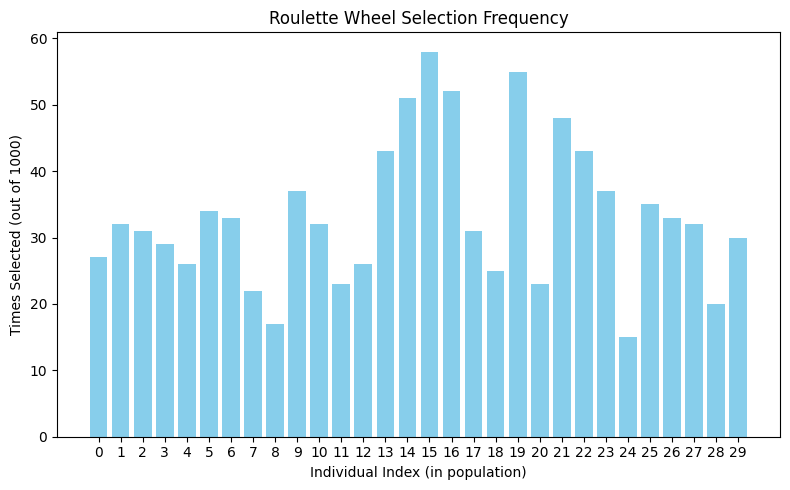

In [539]:
label_roulette, count_roulette = run_selection(sel_roulette, "Roulette Wheel")
plot_selection_counts(label_roulette, count_roulette)

### 📶 **6.2. Rank-Based Selection**

In [540]:
selected_rank = sel_rank(population, fitness)
print_selected("Rank Selection", selected_rank)


Rank Selection
Selected 1 - Fitness: 0.7137


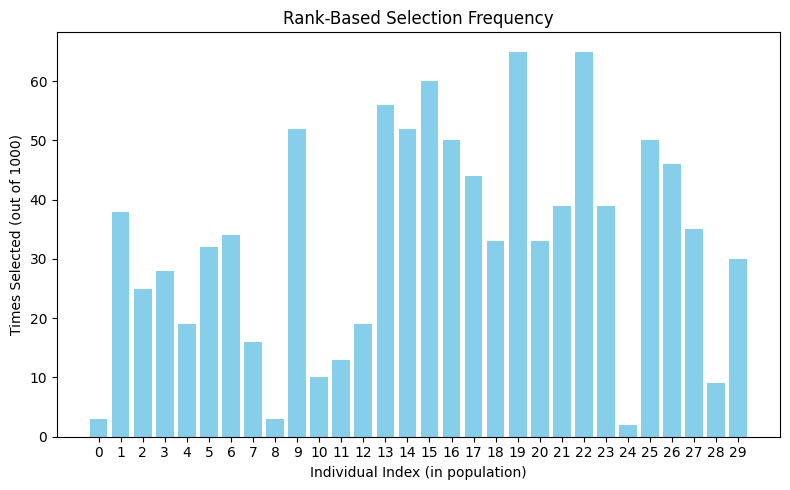

In [541]:
label_rank, count_rank = run_selection(sel_rank, "Rank-Based")
plot_selection_counts(label_rank, count_rank)

### 🏆 **6.3. Tournament Selection**

In [542]:
selected_tournament = sel_tournament(population, fitness, k=3)
print_selected("Tournament Selection", selected_tournament)


Tournament Selection
Selected 1 - Fitness: 0.7251


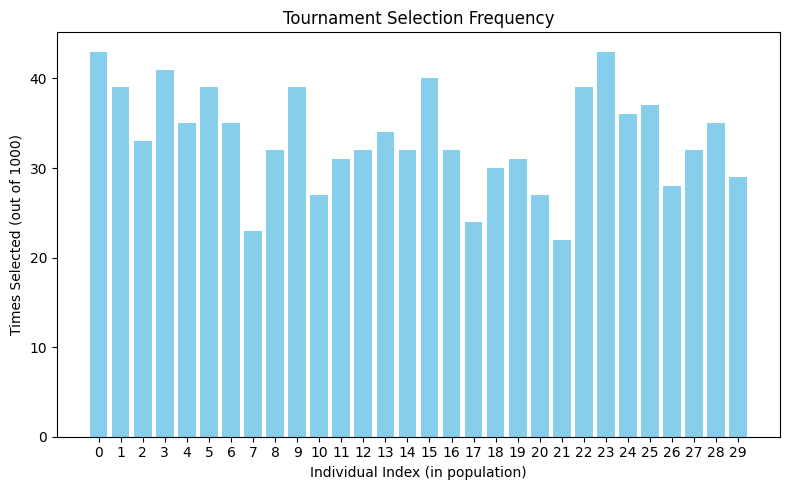

In [543]:
label_tournament, count_tournament = run_selection(sel_tournament, "Tournament", k=3)
plot_selection_counts(label_tournament, count_tournament)

# 🧬 **7. Genetic Algorithm** <a id="7-genetic"></a>

Evaluate all possible combinations

In [545]:
# Run the evaluation for all combinations of selection, crossover, and mutation operators
results = evaluate_all_combinations(
    players_by_position,
    team_structure,
    budget_limit,
    num_teams,
    population_size,
    generations,
    verbose=True
)

Generation 001 | Best: 0.5671 | Avg: 1.0176
Generation 002 | Best: 0.3876 | Avg: 0.8418
Generation 003 | Best: 0.3876 | Avg: 0.7914
Generation 004 | Best: 0.3182 | Avg: 0.7006
Generation 005 | Best: 0.2619 | Avg: 0.7484
Generation 006 | Best: 0.2286 | Avg: 0.7700
Generation 007 | Best: 0.2286 | Avg: 0.7921
Generation 008 | Best: 0.2286 | Avg: 0.6907
Generation 009 | Best: 0.2286 | Avg: 0.6005
Generation 010 | Best: 0.2286 | Avg: 0.5826
Generation 011 | Best: 0.2286 | Avg: 0.6142
Generation 012 | Best: 0.2286 | Avg: 0.6609
Generation 013 | Best: 0.2286 | Avg: 0.5851
Generation 014 | Best: 0.2286 | Avg: 0.5453
Generation 015 | Best: 0.2286 | Avg: 0.4005
Generation 016 | Best: 0.2286 | Avg: 0.4845
Generation 017 | Best: 0.2286 | Avg: 0.3940
Generation 018 | Best: 0.2286 | Avg: 0.4063
Generation 019 | Best: 0.2286 | Avg: 0.3268
Generation 020 | Best: 0.2286 | Avg: 0.4063
Generation 021 | Best: 0.2286 | Avg: 0.4168
Generation 022 | Best: 0.2286 | Avg: 0.3338
Generation 023 | Best: 0.2286 | 

In [546]:
# create a DataFrame to store the results and sort by mean fitness
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="mean_fitness")
display(df_results)

,selection,crossover,mutation,mean_fitness,std_fitness,best_fitness,time_sec
2,sel_roulette,team_crossover,mutation_balance_teams,0.057143,0.000000e+00,0.057143,396.41
5,sel_roulette,position_crossover,mutation_balance_teams,0.057143,0.000000e+00,0.057143,29.90
11,sel_rank,position_crossover,mutation_balance_teams,0.057143,0.000000e+00,0.057143,13.33
8,sel_rank,team_crossover,mutation_balance_teams,0.057143,0.000000e+00,0.057143,383.18
17,sel_tournament,position_crossover,mutation_balance_teams,0.057143,0.000000e+00,0.057143,15.00
7,sel_rank,team_crossover,mutation_regenerate_team,0.073730,2.345786e-02,0.057143,2.76
1,sel_roulette,team_crossover,mutation_regenerate_team,0.073730,2.345786e-02,0.057143,2.40
0,sel_roulette,team_crossover,mutation_swap_players,0.073730,2.345786e-02,0.057143,2.42
6,sel_rank,team_crossover,mutation_swap_players,0.090317,2.345786e-02,0.057143,2.59
14,sel_tournament,team_crossover,mutation_balance_teams,0.101339,3.404259e-02,0.057143,398.09


BEST SOLUTION

In [547]:
# Run the genetic algorithm with the best combination of operators
best_solution_final = genetic_algorithm(
    players_by_position,
    team_structure,
    budget_limit,
    num_teams,
    population_size,
    generations,
    selection_fn=sel_roulette,
    crossover_fn=position_crossover,
    mutation_fn=mutation_balance_teams,
    verbose=True
)

Generation 001 | Best: 0.1895 | Avg: 0.9265
Generation 002 | Best: 0.1400 | Avg: 0.9533
Generation 003 | Best: 0.1400 | Avg: 0.8232
Generation 004 | Best: 0.1400 | Avg: 0.8350
Generation 005 | Best: 0.1400 | Avg: 0.7407
Generation 006 | Best: 0.0571 | Avg: 0.8612
Generation 007 | Best: 0.0571 | Avg: 0.9132
Generation 008 | Best: 0.0571 | Avg: 0.7271
Generation 009 | Best: 0.0571 | Avg: 0.8464
Generation 010 | Best: 0.0571 | Avg: 0.9291
Generation 011 | Best: 0.0571 | Avg: 0.9639
Generation 012 | Best: 0.0571 | Avg: 0.8674
Generation 013 | Best: 0.0571 | Avg: 0.8015
Generation 014 | Best: 0.0571 | Avg: 0.7988
Generation 015 | Best: 0.0571 | Avg: 0.8596
Generation 016 | Best: 0.0571 | Avg: 0.8069
Generation 017 | Best: 0.0571 | Avg: 0.9230
Generation 018 | Best: 0.0571 | Avg: 0.8389
Generation 019 | Best: 0.0571 | Avg: 1.0397
Generation 020 | Best: 0.0571 | Avg: 0.8198
Generation 021 | Best: 0.0571 | Avg: 0.9850
Generation 022 | Best: 0.0571 | Avg: 0.8478
Generation 023 | Best: 0.0571 | 

In [548]:
# print the best solution found
print("Best solution found:")
print(best_solution_final)

Best solution found:
<GASolution fitness=0.0571>


In [549]:
# Print the average skill of each team in the best final solution
for i, team in enumerate(best_solution_final.individual.league):
    print(f"Team {i+1} - Avg Skill: {team.avg_skill():.2f}")

Team 1 - Avg Skill: 86.43
Team 2 - Avg Skill: 86.43
Team 3 - Avg Skill: 86.43
Team 4 - Avg Skill: 86.29
Team 5 - Avg Skill: 86.43


In [550]:
# Print detailed info about the best final solution
print_league_details(best_solution_final.individual)


     (Fitness: 0.0571)

  Team 1
  - GK: Jordan Smith | Skill: 88 | Salary: €100M
  - DEF: Owen Parker | Skill: 88 | Salary: €100M
  - DEF: Lucas Bennett | Skill: 85 | Salary: €90M
  - MID: Austin Torres | Skill: 82 | Salary: €80M
  - MID: Dylan Morgan | Skill: 91 | Salary: €115M
  - FWD: Chase Murphy | Skill: 86 | Salary: €95M
  - FWD: Adrian Collins | Skill: 85 | Salary: €90M
  Avg Skill: 86.43 |Total Salary: €670M

  Team 2
  - GK: Blake Henderson | Skill: 87 | Salary: €95M
  - DEF: Ethan Howard | Skill: 80 | Salary: €70M
  - DEF: Maxwell Flores | Skill: 81 | Salary: €72M
  - MID: Dominic Bell | Skill: 86 | Salary: €95M
  - MID: Hunter Cooper | Skill: 83 | Salary: €85M
  - FWD: Sebastian Perry | Skill: 95 | Salary: €150M
  - FWD: Elijah Sanders | Skill: 93 | Salary: €140M
  Avg Skill: 86.43 |Total Salary: €707M

  Team 3
  - GK: Ryan Mitchell | Skill: 83 | Salary: €85M
  - DEF: Jaxon Griffin | Skill: 79 | Salary: €65M
  - DEF: Caleb Fisher | Skill: 84 | Salary: €85M
  - MID: Ashton

True